In [1]:
import torch
import gym

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
env = gym.make('CartPole-v0')
env.reset()

array([-0.00736315,  0.04347463,  0.00091341, -0.01764542], dtype=float32)

In [4]:
config = {
    'device': 0,
    'epoc': 60,
    'learning_rate': 0.001,
    'epsilon': 0.9,
    'discount': 0.8,
    'n_action': env.action_space.n, 
    'n_state': 4,  
    'n_hidden': 128,
    'batch_size': 64, 
    'buffer_capacity': 100000
}

print(config['device'])
print(config['n_action'])
print(config['n_state'])

0
2
4


In [5]:
class DQN(torch.nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim) -> None:
        super(DQN, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        return self.fc3(x)

net = DQN(config['n_state'], config['n_action'], config['n_hidden']).to(config['device'])
target_net = DQN(config['n_state'], config['n_action'], config['n_hidden']).to(config['device'])

In [6]:
def choose_act(state, net:DQN, config):
    if random.uniform(0,1) < config['epsilon']:
        state = torch.FloatTensor(state).unsqueeze(dim=0).to(config['device'])
        with torch.no_grad():
            return torch.argmax(net(state), dim=1).item()
    else:
        return random.randrange(config['n_action'])
         

In [7]:
class Buffer():
    def __init__(self, capacity) -> None:
        self.total_record = []
        self.capacity = capacity
        self.position = 0

    def push_buffer(self, buffer_record):
        if len(self.total_record) < self.capacity:
            self.total_record.append(None)
        self.total_record[self.position] = buffer_record
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        batch = random.sample(self.total_record, batch_size)
        a, s, next_s, r, done = zip(*batch)
        return a, s, next_s, r, done
        
buffer = Buffer(config['buffer_capacity'])

In [8]:
def update(optimize, buffer:Buffer, config, target_net:DQN, net:DQN):
    if len(buffer.total_record) < config['batch_size']:
        return 
    device = config['device']
    sample_a, sample_s, sample_next_s, sample_r, sample_done = buffer.sample(config['batch_size'])
    sample_a, sample_s, sample_next_s, sample_r, sample_done = \
        torch.LongTensor(sample_a).unsqueeze(1).to(device), \
        torch.FloatTensor(sample_s).to(device), \
        torch.FloatTensor(sample_next_s).to(device), \
        torch.FloatTensor(sample_r).to(device), \
        torch.FloatTensor(np.float32(sample_done)).to(device)
    qvalue = net(sample_s).gather(dim=1, index=sample_a).squeeze(1)
    expect_qvalue = sample_r + config['discount'] * torch.max(target_net(sample_next_s), dim=1)[0] * (1-sample_done)

    loss = torch.nn.MSELoss()(qvalue, expect_qvalue)

    optimize.zero_grad()
    loss.backward()
    optimize.step()

In [9]:
def train(env, config, buffer:Buffer, net:DQN, target_net:DQN):
    optimize = torch.optim.Adam(net.parameters(), lr=config['learning_rate'])
    total_reward = []
    for i in range(1, config['epoc']+1):
        buffer_s = env.reset()
        ep_reward = 0
        while True:
            buffer_a = choose_act(buffer_s, net, config)
            buffer_next_s, buffer_r, buffer_done, _ = env.step(buffer_a)
            buffer.push_buffer((buffer_a, buffer_s, buffer_next_s, buffer_r, buffer_done))
            buffer_s = buffer_next_s
            update(optimize, buffer, config, target_net, net)
            ep_reward += buffer_r
            if buffer_done:
                break

        total_reward.append(ep_reward)
        if i % 10 == 0:
            print('epoc: {}|{}, reward = {}'.format(i, config['epoc'], ep_reward))

        if i % 5 == 0:
            target_net.load_state_dict(net.state_dict())
    
    return total_reward

In [10]:
def plot(record):
    plt.plot(range(len(record)), record)
    plt.show()

epoc: 10|60, reward = 18.0
epoc: 20|60, reward = 16.0
epoc: 30|60, reward = 16.0
epoc: 40|60, reward = 9.0
epoc: 50|60, reward = 11.0
epoc: 60|60, reward = 146.0


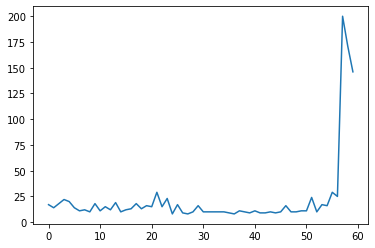

In [11]:
total_reward = train(env, config, buffer, net, target_net)
plot(total_reward)

In [ ]:
def eval(net, env, config):
    s = env.reset()
    while True:
        env.render()
        s = torch.FloatTensor(s).unsqueeze(dim=0).to(config['device'])
        with torch.no_grad():
            a = torch.argmax(net(s), dim=1).cpu().item()
        next_s, reward, done, _ = env.step(a)
        s = next_s
        if done:
            break
    env.close()

In [ ]:
eval(net, env, config)

In [ ]:
s = env.reset()
while True:
    env.render()
    next_s, reward, done, _ = env.step(int(np.random.choice([0,1], 1)))
    s = next_s
    if done:
        break
env.close()